In [8]:
import os
import hashlib
import time
import torch
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.font_manager as fm
from Bio import SeqIO
from tqdm import tqdm
from functools import partial
from datetime import datetime
from torch.utils.data import DataLoader, Dataset, Subset
from transformers import (
    EsmTokenizer,
    EsmForMaskedLM,
    AutoTokenizer,
    AutoModel
)
from peft import PeftModel
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report, roc_curve

In [3]:
def generate_anchor_embeddings_batch(sequences, tokenizer, model, device, batch_size=32):
    model.to(device)
    embeddings = []
    for i in range(0, len(sequences), batch_size):
        batch_sequences = sequences[i:i + batch_size]
        inputs = tokenizer(batch_sequences, return_tensors="pt", padding=True)
        inputs = {key: value.to(device) for key, value in inputs.items()}
        with torch.no_grad():
            output = model.esm(**inputs).last_hidden_state
            mean_output = output[:, 1:output.size(1)].mean(dim=1)
        embeddings.append(mean_output.cpu())
        torch.cuda.empty_cache()
    return torch.cat(embeddings, dim=0)

def generate_mol_embeddings_batch(smiles_list, tokenizer, model, device, batch_size=32):
    model.to(device)
    embeddings = []
    for i in range(0, len(smiles_list), batch_size):
        batch_smiles = smiles_list[i:i + batch_size]
        inputs = tokenizer(batch_smiles, padding=True, return_tensors="pt")
        inputs = {key: value.to(device) for key, value in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
            mol_embedding = outputs.pooler_output
        embeddings.append(mol_embedding.cpu())
        torch.cuda.empty_cache()
    return torch.cat(embeddings, dim=0)

In [4]:
class Coembedding(nn.Module):
    def __init__(
        self,
        molecule_shape=768,
        protein_shape=1280,
        latent_dimension=1024,
        latent_activation=nn.ReLU,
        latent_distance="Cosine",
        classify=True,
        temperature=0.1
    ):
        super(Coembedding, self).__init__()
        self.molecule_projector = nn.Sequential(
            nn.Linear(molecule_shape, latent_dimension),
            latent_activation(),
            nn.Linear(latent_dimension, latent_dimension)
        )
        self.protein_projector = nn.Sequential(
            nn.Linear(protein_shape, latent_dimension),
            latent_activation(),
            nn.Linear(latent_dimension, latent_dimension)
        )
        self.temperature = nn.Parameter(torch.tensor(temperature))
        self.do_classify = classify

        if classify:
            self.distance_metric = latent_distance
            self.activator = nn.CosineSimilarity(dim=-1)

    def forward(self, molecule, protein):
        if self.do_classify:
            return self.classify(molecule, protein)

    def classify(self, molecule, protein):
        molecule_projection = self.molecule_projector(molecule)
        protein_projection = self.protein_projector(protein)

        molecule_projection = molecule_projection.unsqueeze(0) 
        protein_projection = protein_projection.unsqueeze(1)
        
        distance = self.activator(molecule_projection, protein_projection)
        scaled_distance = distance / self.temperature
        return scaled_distance

In [ ]:
model_name = '../models/esm2/esm2_t33_650M_UR50D'
prot_tokenizer = EsmTokenizer.from_pretrained(model_name)
base_model = EsmForMaskedLM.from_pretrained(model_name)
prot_model = PeftModel.from_pretrained(base_model, '../models/plm')

mol_model_path = "../models/ibm/MoLFormer-XL-both-10pct"
mol_tokenizer = AutoTokenizer.from_pretrained(mol_model_path, trust_remote_code=True)
mol_model = AutoModel.from_pretrained(mol_model_path, deterministic_eval=True, trust_remote_code=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data = pd.read_excel("../data/T2_data_norm.csv")
data = data.drop_duplicates(subset = ['canonicalsmiles'])

prot_seq = data.sequence.tolist()
mol_smiles = data.canonicalsmiles.tolist()

prot_emb = generate_anchor_embeddings_batch(
        prot_seq, prot_tokenizer, prot_model, device
    )

mol_emb = generate_mol_embeddings_batch(
        mol_smiles, mol_tokenizer, mol_model, device
    )

model = Coembedding().to(device)
model.load_state_dict(torch.load('../models/best_model.pth')['model_state_dict'])
model.eval()

Coembedding(
  (molecule_projector): Sequential(
    (0): Linear(in_features=768, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (protein_projector): Sequential(
    (0): Linear(in_features=1280, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (activator): CosineSimilarity()
)

In [ ]:
import torch
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

from Bio import SeqIO
from sklearn.metrics import roc_curve
from sklearn.tree import DecisionTreeClassifier


# Compute softmax output from the model
with torch.no_grad():
    prot_emb = prot_emb.to(device)
    mol_emb = mol_emb.to(device)
    output = F.softmax(model(mol_emb, prot_emb), dim=-1)
    output_np = output.cpu().detach().numpy()

# Extract diagonal elements as positive samples
positive_samples = output_np.diagonal()

# Extract the average of non-diagonal elements in each column as negative samples
negative_samples = np.mean(output_np - np.diag(np.diag(output_np)), axis=0)

# Construct features (X) and labels (y)
X = np.concatenate([positive_samples, negative_samples])
y = np.concatenate([np.ones(len(positive_samples)), np.zeros(len(negative_samples))])

# Train a Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X.reshape(-1, 1), y)  # Reshape data to fit sklearn's input format

# Read the FASTA file to retrieve protein sequences
fasta_file = "../data/ksb_2566.fasta"
prot_names = [record.id for record in SeqIO.parse(fasta_file, "fasta")]
prot_seq = [str(record.seq) for record in SeqIO.parse(fasta_file, "fasta")]

# Process protein sequences in batches
batch_size = 1000  # Process 1000 sequences per batch
max_similarities_list = []

for i in range(0, len(prot_seq), batch_size):
    # Get a batch of protein sequences
    batch_prot_seq = prot_seq[i:i+batch_size]
    
    # Generate embeddings for the batch
    prot_emb = generate_anchor_embeddings_batch(batch_prot_seq, prot_tokenizer, prot_model, device)
    
    with torch.no_grad():
        prot_emb = prot_emb.to(device)
        mol_emb = mol_emb.to(device)
        # Compute the similarity matrix
        similarity_matrix = F.softmax(model(mol_emb, prot_emb), dim=-1)
        
    # Find the maximum similarity value for each molecule
    max_similarities = torch.max(similarity_matrix, dim=1).values
    max_similarities_list.append(max_similarities.cpu().numpy())

# Combine results from all batches
max_similarities_np = np.concatenate(max_similarities_list)

# Predict the test set
y_pred = clf.predict(max_similarities_np.reshape(-1, 1))

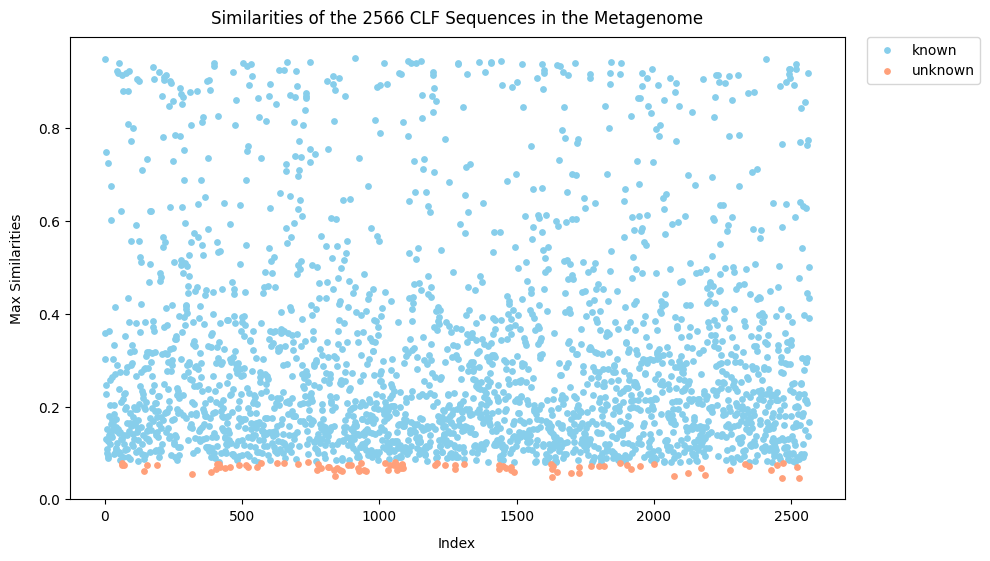

In [ ]:
# Create a new figure
plt.figure(figsize=(10, 6))

# Plot scatter points for elements where y_pred == 1 (known), colored in blue
plt.scatter(np.where(y_pred == 1)[0] + 1,  # Add 1 to indices for 1-based indexing
            max_similarities_np[y_pred == 1], 
            c='skyblue', label='known', s=15, alpha=1)

# Plot scatter points for elements where y_pred == 0 (unknown), colored in red
plt.scatter(np.where(y_pred == 0)[0] + 1,  # Add 1 to indices for 1-based indexing
            max_similarities_np[y_pred == 0], 
            c='lightsalmon', label='unknown', s=15, alpha=1)

# Add legend
plt.legend()

# Add title and axis labels
plt.title('Similarities of the 2566 CLF Sequences in the Metagenome', fontsize=12, pad=10)
plt.xlabel('Index', labelpad=10)
plt.ylabel('Max Similarities', labelpad=10)

# Adjust legend position
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.95))

# Save the plot as a PNG file
plt.savefig('../figures/figure-4.png', format='png', dpi=600, bbox_inches='tight')

# Display the plot
plt.show()

/tmp/ipykernel_24594/1752273720.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlBu_r')
/tmp/ipykernel_24594/1752273720.py:24: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), pad=0.02)


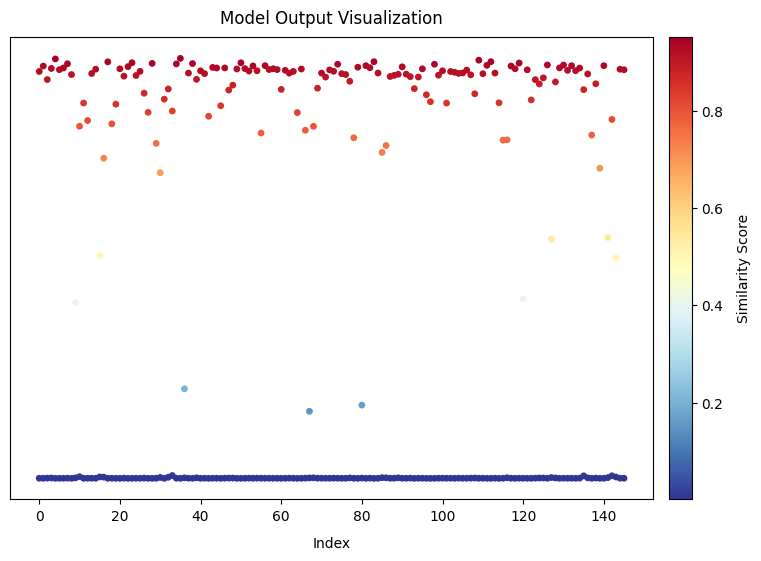

In [ ]:
# Create labels: 1 for matches (positive samples) and 0 for non-matches (negative samples)
labels = np.concatenate([np.ones(len(positive_samples)), np.zeros(len(negative_samples))])
scores = np.concatenate([positive_samples, negative_samples])

# Create x-axis values for plotting (indices for positive samples)
x = np.arange(positive_samples.size)

# Create a new figure for the scatter plot
plt.figure(figsize=(10, 6))

# Generate a color mapping based on the similarity scores (positive and negative)
norm = plt.Normalize(vmin=min(scores), vmax=max(scores))
cmap = plt.cm.get_cmap('RdYlBu_r')

# Scatter plot for positive samples with gradient colors
plt.scatter(x, positive_samples, c=positive_samples, cmap=cmap, norm=norm, 
            s=15, label='Positive Values')

# Scatter plot for negative samples with gradient colors
plt.scatter(x, negative_samples, c=negative_samples, cmap=cmap, norm=norm, 
            s=15, label='Negative Values')

# Add a color bar to show the mapping between similarity scores and colors
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), pad=0.02)
cbar.set_label('Similarity Score', labelpad=10, fontsize=10)

# Add a plot title and axis labels
plt.title('Model Output Visualization', fontsize=12, pad=10)
plt.xlabel('Index', labelpad=10)

# Optionally hide y-axis ticks for a cleaner look
plt.yticks([])

# Save the figure as a high-quality PNG file
plt.savefig('../figures/figure-3.png', format='png', dpi=600)

# Display the plot
plt.show()